In [80]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_olivetti_faces

In [82]:
# 下载数据
olivetti_faces = fetch_olivetti_faces(data_home='./olivetti', shuffle=True)

In [83]:
# 引入模型
device = "cuda" if torch.cuda.is_available() else "cpu"
model = nn.Sequential(
    nn.Linear(4096, 2048),
    nn.BatchNorm1d(2048),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(2048, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, 40)
).to(device)


In [84]:
# 超参数
LR = 1e-3
EPOCHS = 150

In [85]:
#损失函数
loss_fn = nn.CrossEntropyLoss()

In [86]:
#初始数据
origin_input = torch.tensor(olivetti_faces.data)
target = torch.tensor(olivetti_faces.target).long()

In [87]:
def train(epoches, model, input, target, loss_fn, optimizer_order):
    loss_his = []
    #优化器
    sgd = optim.SGD(params=model.parameters(),lr=LR)    #原始sgd
    sgd_monment = optim.SGD(params=model.parameters(),lr=LR,momentum=0.5,weight_decay=1e-4)   #加入动量、权重衰减
    adam = optim.Adam(params=model.parameters(),lr=LR,weight_decay=1e-4)
    adamW = optim.AdamW(params=model.parameters(),lr=LR,weight_decay=1e-4)
    if optimizer_order == 1:
        optimizer = sgd
    elif optimizer_order == 2:
        optimizer = sgd_monment
    elif optimizer_order == 3:
        optimizer = adam
    elif optimizer_order == 4:
        optimizer = adamW
    for i in range(epoches):
        output = model(input)
        loss = loss_fn(output, target)
        loss_his.append(loss.item())
        model.zero_grad()
        loss.backward()
        optimizer.step()
    return loss_his

In [88]:
#创建4个相同的model
models = nn.ModuleList([model for _ in range(4)])

In [89]:
train_hists = [train(epoches=EPOCHS, model=m, input=origin_input.to(device), target=target.to(device), loss_fn=loss_fn, optimizer_order=order)
               for m,order in zip(models,[1,2,3,4])]


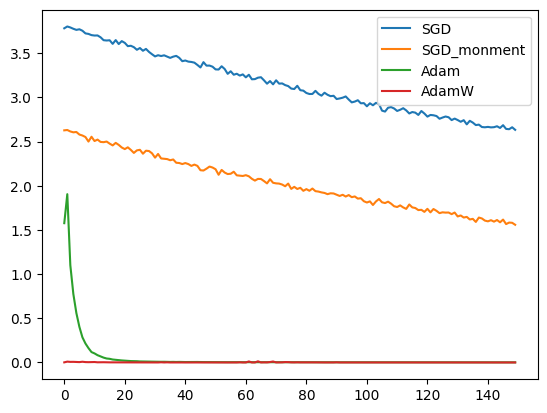

In [90]:
# 回值对比图
import matplotlib.pyplot as plt
import numpy as np
plot_y = np.arange(0,EPOCHS,1)
plt.plot(plot_y, train_hists[0], label='SGD')
plt.plot(plot_y, train_hists[1], label='SGD_monment')
plt.plot(plot_y, train_hists[2], label='Adam')
plt.plot(plot_y, train_hists[3], label='AdamW')
plt.legend()
plt.show()